In this example we use CVXPY to train a SVM classifier with $\ell_2-regularization$. We are given data $(x_i,y_i), i=1,\ldots, m$. The $x_i \in {\bf R}^n$ are feature vectors, while the $y_i \in \{\pm 1\}$ are associated boolean outcomes. Our goal is to construct a good linear classifier $\hat y = {\rm sign}(\beta^T x - v)$. We find the parameters $\beta,v$ by minimizing the (convex) function

$$f(\beta,v) = (1/m) \sum_i \left(1 - y_i ( \beta^T x_i-v) \right)_+ + \lambda
\| \beta\|_2$$
The first term is the average hinge loss. The second term shrinks the coefficients in \beta and encourages sparsity. The scalar $\lambda \geq 0$ is a (regularization) parameter. Minimizing $f(\beta,v)$ simultaneously selects features and fits the classifier.

In [301]:
import preprocessing as pp

import pandas as pd
import numpy as np
import csv
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import confusion_matrix


In [302]:
all_dtypes = pp.CollectDataTypes().get_dict_all_dtypes(label='int16')
subset_df = pd.read_csv('all_data.csv', dtype=all_dtypes, index_col=0)

In [303]:
# Prediction with just the numerical features
# numerical_cols = subset_df.select_dtypes(exclude=['object']).columns


# TRAIN - TEST splitting
subset_df_ = subset_df.dropna(how='any')

In [322]:
default_clients_df = subset_df_[subset_df_['loan_status'] == 1]
default_clients_df.shape

(11335, 51)

In [329]:
non_default_clients_df = subset_df_[subset_df_['loan_status'] == 0]
non_default_clients_df = non_default_clients_df.sample(20000)
non_default_clients_df.shape

(20000, 51)

In [331]:
selected_df = pd.concat([non_default_clients_df, default_clients_df])
selected_df.shape

(31335, 51)

In [337]:
X_train, X_test, y_train, y_test = train_test_split(selected_df[numerical_cols], 
                                                    selected_df['loan_status'],
                                                    test_size=0.3, random_state=42)
del X_train['loan_status']
del X_test['loan_status']

In [339]:
y_train.value_counts()

0    13985
1     7949
Name: loan_status, dtype: int64

In [340]:
y_train = list(y_train)
for i in range(len(y_train)):
    if y_train[i] == 0:
        y_train[i] = -1
    else:
        y_train[i] = 1

In [341]:
y_test = list(y_test)
for i in range(len(y_test)):
    if y_test[i] == 0:
        y_test[i] = -1
    else:
        y_test[i] = 1

In [346]:
y_train = np.array(y_train).reshape(-1,1)

In [342]:
y_test = np.array(y_test).reshape(-1,1)

In [233]:
# # plt.plot(X_train[:, 1], X_train[:, 2], 'o')
# colors = [int(i) for i in y_train]
# plt.scatter(X_train[:, 0], (X_train[:, 9]), c=colors, cmap=plt.cm.cool)

### Standardize data

In [343]:
normalizer_ = Normalizer()
normalizer_.fit(X_train)

X_train = normalizer_.transform(X_train)
X_test = normalizer_.transform(X_test)

In [297]:
# scaler = StandardScaler()
# scaler.fit(X_train)

# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

### Optimization with oversampling

In [298]:
# from imblearn.over_sampling import SMOTE

# sm = SMOTE(sampling_strategy='minority')
# x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

# # Shuffle dataset
# indexes = np.arange(len(x_train_res))
# np.random.shuffle(indexes)

# X = x_train_res[indexes]
# Y = np.array(y_train_res[indexes]).reshape(-1, 1)

In [352]:
m, n = X.shape

beta = cp.Variable((n, 1))
v = cp.Variable((1,1))
loss = cp.sum(cp.pos(1 - cp.multiply(y_train, X_train*beta - v)))
reg = cp.sum_squares(beta)
lambd = cp.Parameter(nonneg=True)
prob = cp.Problem(cp.Minimize(loss/m + lambd*reg))

In [353]:
# Compute a trade-off curve and record train and test error.
np.random.seed(123)

TRIALS = 10
train_error = np.zeros(TRIALS)
test_error = np.zeros(TRIALS)
train_acc = np.zeros(TRIALS)
test_acc = np.zeros(TRIALS)

lambda_vals = np.logspace(-6, 0, TRIALS)
beta_vals = [] 

for i in range(TRIALS):
    lambd.value = lambda_vals[i]
    prob.solve(verbose=False)
    print(v.value)
    y_pred_tr = np.sign(X.dot(beta.value) - v.value)
    y_pred_te = np.sign(X_test.dot(beta.value) - v.value)
    train_error[i] = (Y != y_pred_tr).sum()/len(Y)
    test_error[i] = (y_test != y_pred_te).sum()/len(y_test)
    train_acc[i] = accuracy_score(Y, y_pred_tr)
    test_acc[i] = accuracy_score(y_test, y_pred_te)
    beta_vals.append(beta.value)

[[1.00791855]]
[[1.00251301]]
[[1.00054053]]
[[1.00013512]]
[[1.00003654]]
[[1.00000835]]
[[1.00000268]]
[[1.00000056]]
[[1.00000012]]
[[1.00000002]]


In [ ]:
# for i in range(len(y_true_tr)):
#     print(Y[i] ,y_pred_tr[i])

# solver='ECOS',

# confusion_matrix(Y, y_pred_tr)

Text(0.5, 0, '$\\lambda$')

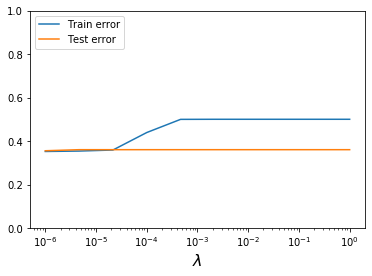

In [357]:
#PLOT

plt.plot(lambda_vals, train_error, label="Train error")
plt.plot(lambda_vals, test_error, label="Test error")
# plt.plot(lambda_vals, train_acc, label="Train acc")
# plt.plot(lambda_vals, test_acc, label="Test acc")
plt.ylim(0,1)
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r"$\lambda$", fontsize=16)

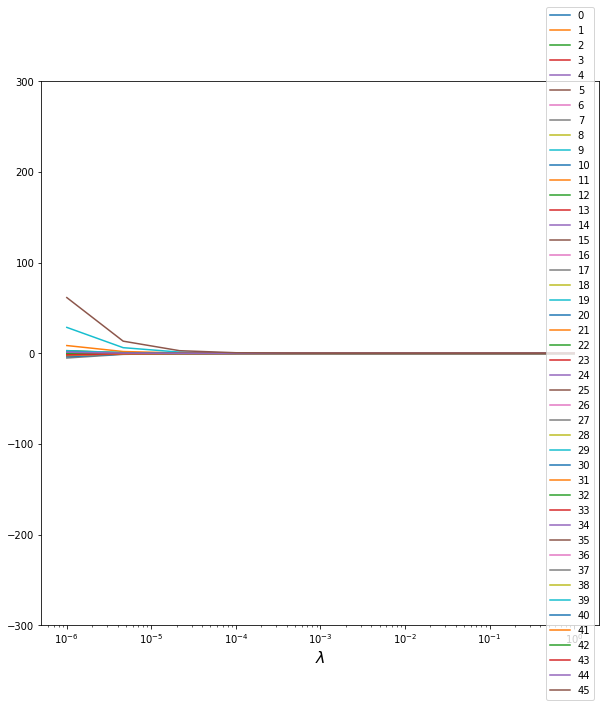

In [355]:
# Plot the regularization path for beta.
plt.figure(figsize=(10,10))
for i in range(n):
    plt.plot(lambda_vals, [wi[i,0] for wi in beta_vals], label=str(i))
    plt.ylim(-300, 300)
plt.legend(loc='right')
plt.xlabel(r"$\lambda$", fontsize=16)
plt.xscale("log")

In [358]:
### Best params

m, n = X.shape

beta = cp.Variable((n, 1))
v = cp.Variable((1,1))
loss = cp.sum(cp.pos(1 - cp.multiply(Y, X*beta - v)))
reg = cp.sum_squares(beta)
lambd = cp.Parameter(nonneg=True)
prob = cp.Problem(cp.Minimize(loss/m + lambd*reg))

lambd.value = 10**(-6)
prob.solve(verbose=False)

Solver interrupted


ValueError: OSQP solve error!

In [ ]:
y_pred_tr = np.sign(X.dot(beta.value) - v.value)
y_pred_te = np.sign(X_test.dot(beta.value) - v.value)

train_error = (Y != y_pred_tr).sum()/len(Y)
test_error = (y_test != y_pred_te).sum()/len(y_test)

train_acc = accuracy_score(Y, y_pred_tr)
test_acc = accuracy_score(y_test, y_pred_te)

print("train\n", confusion_matrix(Y, y_pred_tr))
print("\ntest\n", confusion_matrix(y_test, y_pred_te))

print("\nACC: train = {}, test {}".format(train_acc, test_acc))
